In [2]:
# import modules/downloads

import pandas as pd
import re
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

import os


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hiennguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [3]:
# load test data files

test_set = pd.read_csv("test.txt", sep=";")
train_set = pd.read_csv("train.txt", sep=";")
val_set = pd.read_csv("val.txt", sep=";")
val_set.columns = ["text","sentiment"]
val_set.head()


,text,sentiment
0,i feel like i am still looking at a blank canv...,sadness
1,i feel like a faithful servant,love
2,i am just feeling cranky and blue,anger
3,i can have for a treat or if i am feeling festive,joy
4,i start to feel more appreciative of what god ...,joy


In [4]:
# Data cleaning/preprocessing

# Remove punctuation
val_set['text'] = \
val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Make titles lowercase
val_set['text'] = \
val_set['text'].map(lambda x: x.lower())

# first rows of text
val_set['text'].head()


<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
<ipython-input-4-7563c84c855d>:5: DeprecationWarning: invalid escape sequence \.
  val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    i feel like i am still looking at a blank canv...
1                       i feel like a faithful servant
2                    i am just feeling cranky and blue
3    i can have for a treat or if i am feeling festive
4    i start to feel more appreciative of what god ...
Name: text, dtype: object

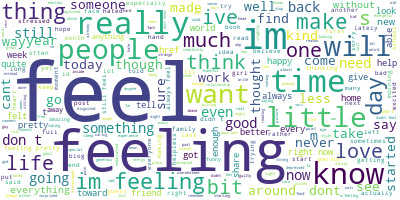

In [5]:
# visual wordcloud exploratory analysis

# Join processed titles
joined_titles = ','.join(list(val_set['text'].values))

# WordCloud object
word_cloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# show word cloud
word_cloud.generate(joined_titles)
word_cloud.to_image()


In [6]:
#transform text data to useful training LDA model input

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'feel', 'feeling', 'really', 'im','ive'])

def tokenize_text(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # remove punctuations
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = val_set.text.values.tolist()
tokenized_words = list(tokenize_text(data))

tokenized_words = remove_stopwords(tokenized_words)
print(tokenized_words[:1][0][:10])


['like', 'still', 'looking', 'blank', 'canvas', 'blank', 'pieces', 'paper']


In [7]:
# convert tokenized object into a corpus and dictionary

# Dictionary
id2word = corpora.Dictionary(tokenized_words)
# Corpus
texts = tokenized_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:10])


[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [8]:
# build model with 6 topics (main emotions)

# number of topics
num_topics = 6

lda_mod = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print Keyword in topics
pprint(lda_mod.print_topics())
doc_lda = lda_mod[corpus]


[(0,
  '0.036*"im" + 0.026*"like" + 0.011*"know" + 0.008*"want" + 0.008*"still" + '
  '0.006*"think" + 0.005*"get" + 0.005*"even" + 0.004*"things" + '
  '0.004*"something"'),
 (1,
  '0.013*"like" + 0.013*"im" + 0.008*"much" + 0.007*"get" + 0.007*"people" + '
  '0.007*"love" + 0.005*"time" + 0.005*"pretty" + 0.005*"day" + 0.004*"want"'),
 (2,
  '0.007*"like" + 0.006*"bit" + 0.006*"time" + 0.005*"started" + 0.005*"life" '
  '+ 0.004*"want" + 0.004*"get" + 0.004*"little" + 0.004*"ive" + 0.003*"im"'),
 (3,
  '0.024*"like" + 0.010*"know" + 0.008*"im" + 0.007*"little" + 0.005*"would" + '
  '0.004*"never" + 0.004*"someone" + 0.004*"things" + 0.004*"dont" + '
  '0.004*"going"'),
 (4,
  '0.013*"im" + 0.011*"like" + 0.007*"time" + 0.007*"life" + 0.007*"people" + '
  '0.006*"little" + 0.006*"back" + 0.006*"things" + 0.005*"know" + '
  '0.005*"love"'),
 (5,
  '0.013*"like" + 0.010*"im" + 0.008*"ive" + 0.006*"would" + 0.006*"something" '
  '+ 0.006*"make" + 0.005*"get" + 0.005*"could" + 0.005*"litt

In [9]:
# Visualize the topics
cwd = os.getcwd()
directory = os.path.join(cwd, 'results/lda_vis_'+str(num_topics))
if not os.path.exists(directory):
    os.makedirs(directory)

pyLDAvis.enable_notebook()
LDAvis_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

if 1 == 1:
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_mod, corpus, id2word)
    with open(LDAvis_filepath, 'wb') as f:
        pickle.dump(LDA_vis, f)

# load pyLDAvis data from disk
with open(LDAvis_filepath, 'rb') as f:
    LDA_vis = pickle.load(f)
pyLDAvis.save_html(LDA_vis, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDA_vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.065118  0.007793       1        1  20.612740
4      0.001988 -0.021236       2        1  19.843695
1      0.002903 -0.021139       3        1  17.896940
5      0.001260 -0.081011       4        1  15.586009
3      0.038483  0.083549       5        1  13.637261
2     -0.109752  0.032045       6        1  12.423355, topic_info=       Term        Freq       Total Category  logprob  loglift
106      im  249.000000  249.000000  Default  30.0000  30.0000
2      like  262.000000  262.000000  Default  29.0000  29.0000
233     ive   49.000000   49.000000  Default  28.0000  28.0000
775    much   53.000000   53.000000  Default  27.0000  27.0000
332    love   50.000000   50.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
79     know    6.448223   98.412739   Topic6  -5.7442  -0.6398
146     one    5.342741   46.868921   Topic6  -5.9322  -0.0860
106      im    6.868256  249.742847   Topic6  -5.6811  -1.5079
332    love    4.754437   50.284510   Topic6  -6.0489  -0.2730
331  always    4.504130   36.269671   Topic6  -6.1030  -0.0004

[476 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
17        1  0.258403        able
17        2  0.206722        able
17        3  0.103361        able
17        4  0.051681        able
17        5  0.310083        able
...     ...       ...         ...
1486      4  0.264579         yes
1486      6  0.529158         yes
2426      5  0.891165  youngsters
757       2  0.264922       youve
757       5  0.529843       youve

[996 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 6, 4, 3])